# **Afternoon Trading Pipeline**

In this notebook we will explore the basic pipeline for afternoon trading on 15min interval stock data. We will be working with a portfolio of highly correlated stocks: AAPL, GOOG, QCOM, and TSLA. These stock were highly correlated around Aug - Oct 2022. The stock dataset does not contains timestamps, prices and trading volume, but does not contin any target variables.
- Timestamps &#8594; Interval
- Open/Close/High/Low Prices &#8594; Ratio
- Trading Volume &#8594; Ratio

 We will create the target variable by taking the midpoint of Open/Close prices for M future days and then averaging these values. This target variable is Oridnal and has 3 possible classes: 
- 0 - downward price movement
- 1 - no change
- 2 - upward price movement

The price movements are derived by a threshold that is defined using the IQR method to detect outliers. Currently we use a limit of 1, and every Q1 outlier is classified as "0 - downward price movement", every Q3 outlier is classified as "2 - upward price movement", and all inliers are classified as: "1 - no change".

For this problem we filter the data to only inlcude regular trading hours. Since afterhours trading effects the stock prices, we are interested in only training and predicting by using windows the occur sequentially (i.e. within the same trading day)

## Models

The main model we will be testing in this notebook is a Transformer Encoder. Typically a Transformer has an Encoder and Decoder portion, where the Encoder learns information about which parts of the input sequence are relevant to eachother. The Decoder does the opposite, it takes the continuouss representation learned by the Encoder and learns to generate an ordered output sequence. For the Time Series Classifiecation problem it is unecessary to include the Decoder, we can simply use the Encoder to learn relative correlations of the inputs and add a Vanilla Feed Forward Neural Network to the end of the Encoder Blocks to obtain the desired classification. [Source](https://userweb.cs.txstate.edu/~amk181/AIME_LSTM_Attention_vs_Transformer.pdf).

The Transformer Encoder also relies on positional encoding in order to implement this, we will first project the input vectors into high dimensional space as done [here](https://arxiv.org/pdf/2010.02803.pdf), and then add the positional Encoding as done in the [original paper](https://arxiv.org/pdf/1706.03762.pdf).


In order to compare how effective the Transformer is in modeling seuqential data, we will compare its results to:
- Baseline Model (uses previous predictions)
- Linear Model
- Neural Network
- LSTM

### Library Import

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import pandas_ta as ta
import tensorflow as tf
import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20, 10)
%matplotlib inline

### Local Imports

Get base dir for imports, this allows us to look in the main algotrading folder to import local modules

In [2]:
BASE_DIR = os.path.abspath(os.path.join(os.path.abspath('..'), '..'))
sys.path.append(BASE_DIR)

In [3]:
from data_utils import *
from data_pipeline import *
from window_generator import WindowGenerator
from models.basic_transformer import TransformerModel

### Ensure that GPU is available

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Get the Data
Place all stocks in a Dictionary of DataFrames

In [ ]:
from glob import glob
import re

# get all data .csvs
data_paths = glob(os.path.join(BASE_DIR, r'data\raw\*.csv'))

# get stock DataFrames dict
stock_dfs = get_stocks(data_paths, tgt_window=4, iqr_lim=0.25)

In [7]:
def get_trading_times(df):
    ''' Obtains a cleaned stock price DataFrame, with trading times ranging
        from 9:30 - 4:00
       '''
    
    # ensure that all trading times are sequential, pad missing data with NaNs
    df = df.reindex(pd.date_range(df.index[0], df.index[-1], freq='15min'))
       
    # get regular trading times
    dayofweek = df.index.dayofweek
    hour = df.index.hour
    minute = df.index.minute
    
    df = df.iloc[(dayofweek <= 4)                  # only get M-F
                 & ~((hour == 9) & (minute < 30))  # remove less than 9:30
                 & ((hour >= 9) & (hour <= 16))    # hours 9-16
                 & ~((hour == 16) & (minute > 0))] # remove greater than 16:00
    
    # remove NaNs
    df = df[~df.isna().all(axis=1)]
    
    return df

In [8]:
for name in stock_dfs.keys():
    df = stock_dfs[name]
    # add filtered stock back to stock dict
    stock_dfs[name] = get_trading_times(df)

### Place plots of number of each class for each stock

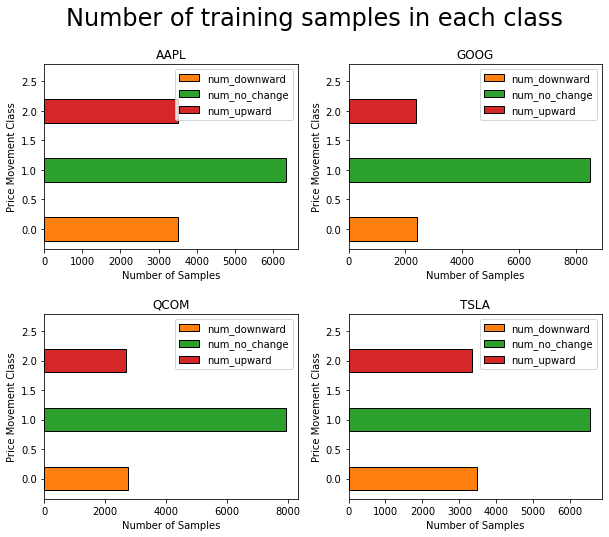

In [9]:
fig = plt.figure(figsize=(10, 8))

for i, name in enumerate(stock_dfs.keys()):
    # get plotting axes
    ax = plt.subplot(2, 2, i + 1)

    # get stock DataFrame
    df = stock_dfs[name]

    # compute class counts
    down = np.sum(df.price_change == 0)
    none = np.sum(df.price_change == 1)
    up = np.sum(df.price_change == 2)

    ax.barh([2.25], [0]) # expand to fit the legend
    ax.barh([0], [down], height=0.4, edgecolor='k', label='num_downward')
    ax.barh([1], [none], height=0.4, edgecolor='k', label='num_no_change')
    ax.barh([2], [up], height=0.4, edgecolor='k', label='num_upward')
    ax.set_title(name)
    ax.set_xlabel('Number of Samples')
    ax.set_ylabel('Price Movement Class')
    ax.legend();

# set main title
fig.suptitle('Number of training samples in each class', size=24)

# add a bit of space
fig.subplots_adjust(hspace=0.35);


### FUTURE -- Add more features 
Add functionalities to data_pipeline module
- Price/Volume Differences
- Time Encoding
- Technical Indicators

### NEW - Add Day of Week to features and remove later

In [10]:
for name in stock_dfs.keys():
    df = stock_dfs[name]
    df['dayofweek'] =  df.index.dayofweek

    stock_dfs[name] = df

    

In [11]:
stock_dfs['AAPL'].iloc[:15, :]

,Open,High,Low,Close,Volume,price_trend,price_change,dayofweek
2020-10-23 09:30:00,114.932978,114.992262,114.893455,114.972501,137430.0,-0.523458,0.0,4
2020-10-23 09:45:00,115.002143,115.160235,114.152398,114.322248,5962724.0,-0.547765,0.0,4
2020-10-23 10:00:00,114.330252,114.448821,113.994306,114.093015,3968090.0,-0.353101,0.0,4
2020-10-23 10:15:00,114.083233,114.083233,113.411341,113.697883,4777513.0,-0.176532,0.0,4
2020-10-23 10:30:00,113.698674,113.885617,113.371818,113.688002,3805439.0,-0.010190,1.0,4
2020-10-23 10:45:00,113.678122,113.984425,113.450864,113.599075,2891741.0,0.041363,1.0,4
2020-10-23 11:00:00,113.598977,113.796691,113.411341,113.668241,2857045.0,-0.012302,1.0,4
2020-10-23 11:15:00,113.668241,113.944902,113.589195,113.865856,2297087.0,-0.235891,0.0,4
2020-10-23 11:30:00,113.865856,113.895498,113.174203,113.495328,3448651.0,-0.256072,0.0,4
2020-10-23 11:45:00,113.490387,113.529910,113.164322,113.317573,2394617.0,-0.077725,1.0,4


### Get train, valid, test splits for each stock

In [12]:
train_dfs = {}
valid_dfs = {}
test_dfs = {}

split_dfs = {}

for name in stock_dfs.keys():

    # get stock DataFrame
    df = stock_dfs[name]

    train = df.loc[:'2022-02-01']
    valid = df.loc['2022-02-02':'2022-07-01']
    test = df.loc['2022-07-01':]

    train_dfs.update({name : train})
    valid_dfs.update({name : valid})
    test_dfs.update({name : test})
    
    split_dfs.update({name : [train, valid, test]})

### Get Data Generators
- One for baseline model
- One for simple non-sequential models (this will use window normalization)
- One for sequential models (This will use window normalization)

First we need to make a Data Generator that that can account for the time spans that we are interested in. We might be able to use specific timestamps to define the windows, i.e. 09:30-13:30

We should strive for a general method of doing this

In [24]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


class WindowGenerator():
    def __init__(self, input_width, label_width, shift, dfs,
                batch_size=32, seed=42, window_norm=True,
                sample_weights=True, 
                remove_columns=[],
                label_columns=None,
                remove_nonsequential=False):
        # Store the raw data.
        self.train_df = dfs[0]
        self.valid_df = dfs[1]
        self.test_df = dfs[2]
      
        # self.position_encode = position_encode
        self.batch_size = batch_size
        self.seed = seed
        self.window_norm = window_norm
        self.sample_weights = sample_weights
        self.remove_columns = remove_columns
        self.label_columns = label_columns
        self.remove_nonsequential = remove_nonsequential # removes non-sequential windows

        # standardize training features if window norm not selected
        if not self.window_norm:
            self.standardize()

        # Work out the label column indices.
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                                enumerate(self.train_df.columns)} 

        # Work out the window parameters.
        self.input_width = input_width # sequence length
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]


    def __repr__(self):
      return '\n'.join([
          f'Total window size: {self.total_window_size}',
          f'Input indices: {self.input_indices}',
          f'Label indices: {self.label_indices}',
          f'Label column name(s): {self.label_columns}'])

    def standardize(self):
        train_mean = self.train_df.mean()
        train_std = self.train_df.std()

        # ensure that target column is not standardized
        for col in set(self.label_columns + self.remove_columns):
            train_mean[col] = 0
            train_std[col] = 1

        self.train_df = (self.train_df - train_mean) / train_std
        self.valid_df = (self.valid_df - train_mean) / train_std
        self.test_df = (self.test_df - train_mean) / train_std


    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]

        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        if self.remove_nonsequential:
            inputs, labels = self.remove_nonsequential_windows(inputs, labels)

        # remove desired columns from input features 
        if len(self.remove_columns) > 0:
            inputs = tf.stack(
                [inputs[:, :, self.column_indices[name]] for name in self.column_indices.keys() 
                                if name not in self.remove_columns],
                axis=-1)

        return inputs, labels


    def standardize_window(self, inputs, labels):
        ''' Standardizes each window to mean - 0 and std - 1'''
        mean = tf.math.reduce_mean(inputs, axis=1)
        std = tf.math.reduce_std(inputs, axis=1)
        
        mean = tf.repeat(tf.expand_dims(mean, axis=1), 
                         self.total_window_size, axis=1)
        std = tf.repeat(tf.expand_dims(std, axis=1), 
                        self.total_window_size, axis=1)

        inputs = tf.math.subtract(inputs, mean)
        inputs = tf.math.divide(inputs, std)

        return inputs, labels


    def get_sample_weights(self, inputs, labels):
        ''' Obtains smaple weights for any number of classes.
            NOTE: sample_weights pertain a weighting to each label
            '''
        # get initial sample weights
        sample_weights = tf.ones_like(labels, dtype=tf.float64)
        
        # get classes and counts for each one
        class_counts = np.bincount(self.train_df.price_change)
        total = class_counts.sum()
        n_classes = len(class_counts)

        for idx, count in enumerate(class_counts):
            # compute weight
            weight = total / (n_classes*count)

            # update weight value 
            sample_weights = tf.where(tf.equal(labels, float(idx)), 
                                      weight, 
                                      sample_weights)
        
        return inputs, labels, sample_weights


    def remove_sequence(self, inputs, labels, sample_weights=None):
        # remove sequence from inputs so simple models can be trained (i.e. Linear Models)
        inputs = tf.expand_dims(inputs[:, 0, :], axis=1)

        if tf.is_tensor(sample_weights):
            return inputs, labels, sample_weights
        else:
            return inputs, labels


    def remove_nonsequential_windows(self, inputs, labels, sample_weights=None):
        # ASSUMES that the dayofweek is the final features
        # get locations of consistent dayofweeks in each batch
        dayofweek_repeats = tf.repeat(tf.expand_dims(inputs[:, 0, -1], axis=1), 
                                      self.input_width, axis=1)
        valid_locs = tf.reduce_all(inputs[:, :, -1] == dayofweek_repeats, axis=1)

        inputs = inputs[valid_locs]
        labels = labels[valid_locs]

        if tf.is_tensor(sample_weights):
            return inputs, labels, sample_weights
        else:
            return inputs, labels
            
    
    def get_position_encoding(self, n=10000):
        d = self.train_df.shape[1] # assume all features are used
        pos_encode = np.zeros((self.input_width, d))
        for k in range(self.input_width):
            for i in np.arange(int(d/2)):
                denominator = np.power(n, 2*i/d)
                pos_encode[k, 2*i] = np.sin(k/denominator)
                pos_encode[k, 2*i+1] = np.cos(k/denominator)
        return pos_encode

    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
                data=data,
                targets=None,
                sequence_length=self.total_window_size,
                sequence_stride=1,
                shuffle=False,
                seed=self.seed,
                batch_size=self.batch_size)

        # get split window
        ds = ds.map(self.split_window)

        if self.window_norm:
            ds = ds.map(self.standardize_window)

        if self.sample_weights:
            ds = ds.map(self.get_sample_weights)

        return ds
    

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def valid(self):
        return self.make_dataset(self.valid_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        # return result

In [29]:
# use shift=0 since the targets are aligned with each feature row
aapl_gen = WindowGenerator(
                input_width=24, label_width=1, shift=0, 
                window_norm=False,
                dfs=split_dfs['AAPL'],
                remove_columns=['price_change', 'price_trend', 'dayofweek'],
                batch_size=32, 
                remove_nonsequential=True,
                label_columns=['price_change'])

In [30]:
for inputs, labels, sample_weights in aapl_gen.train.take(5):
    print(f'Inputs shape (batch, time, features): {inputs.shape}')
    print(f'Labels shape (batch, time, features): {labels.shape}')

Inputs shape (batch, time, features): (8, 24, 5)
Labels shape (batch, time, features): (8, 1, 1)
Inputs shape (batch, time, features): (4, 24, 5)
Labels shape (batch, time, features): (4, 1, 1)
Inputs shape (batch, time, features): (4, 24, 5)
Labels shape (batch, time, features): (4, 1, 1)
Inputs shape (batch, time, features): (4, 24, 5)
Labels shape (batch, time, features): (4, 1, 1)
Inputs shape (batch, time, features): (4, 24, 5)
Labels shape (batch, time, features): (4, 1, 1)


In [31]:
base_gens = []
single_step_gens = []
window_generators = []

for name in split_dfs.keys():
    base_gen = WindowGenerator(
        input_width=1, label_width=1, shift=0,
        dfs=split_dfs[name],
        batch_size=32, 
        label_columns=['price_change'])

    single_gen = WindowGenerator(
                input_width=1, label_width=1, shift=0, 
                window_norm=False,
                dfs=split_dfs[name],
                remove_columns=['price_change', 'price_trend', 'dayofweek'],
                batch_size=32, 
                remove_nonsequential=True,
                label_columns=['price_change'])

    data_gen = WindowGenerator(
                input_width=24, label_width=1, shift=0, 
                window_norm=True,
                dfs=split_dfs[name],
                remove_columns=['price_change', 'price_trend', 'dayofweek'],
                batch_size=32, 
                remove_nonsequential=True,
                label_columns=['price_change'])
    
    base_gens.append(base_gen)
    single_step_gens.append(single_gen)
    window_generators.append(data_gen)

### Start Training Models

In [32]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

In [33]:
train_performance = {}
val_performance = {}

In [34]:
train_metrics = []
val_metrics = []
for data_gen in base_gens:
    baseline = Baseline(label_index=data_gen.column_indices['price_change'])

    baseline.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                     metrics=['accuracy'],
                     weighted_metrics=['accuracy'])

    train_metrics.append(baseline.evaluate(data_gen.train))
    val_metrics.append(baseline.evaluate(data_gen.valid))

88/88 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.3405 - weighted_accuracy: 0.4170


In [35]:
train_performance['Baseline'] = train_metrics
val_performance['Baseline'] = val_metrics

### Train the Linear model
Entire dataset is standardized here

In [36]:
linear = tf.keras.Sequential([
    layers.Dense(units=3, activation='softmax')
])

linear.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    weighted_metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [37]:
train_metrics = []
val_metrics = []

EPOCHS = 2
for e in range(1, EPOCHS+1):
    print(f'\nMAIN EPOCH: {e}')
    for data_gen in single_step_gens:
        print()
        
        history = linear.fit(
                            data_gen.train, epochs=1,
                            validation_data=data_gen.valid)

        train_metrics.append(linear.evaluate(data_gen.train))
        val_metrics.append(linear.evaluate(data_gen.valid))


MAIN EPOCH: 1

88/88 [==============================] - 0s 3ms/step - loss: 1.2942 - sparse_categorical_accuracy: 0.3497 - weighted_sparse_categorical_accuracy: 0.3688

88/88 [==============================] - 0s 3ms/step - loss: 1.5315 - sparse_categorical_accuracy: 0.3569 - weighted_sparse_categorical_accuracy: 0.3782

88/88 [==============================] - 0s 3ms/step - loss: 1.6161 - sparse_categorical_accuracy: 0.3851 - weighted_sparse_categorical_accuracy: 0.2916

88/88 [==============================] - 0s 3ms/step - loss: 1.2610 - sparse_categorical_accuracy: 0.3878 - weighted_sparse_categorical_accuracy: 0.3616

MAIN EPOCH: 2

88/88 [==============================] - 0s 3ms/step - loss: 1.2973 - sparse_categorical_accuracy: 0.3515 - weighted_sparse_categorical_accuracy: 0.3700

88/88 [==============================] - 0s 3ms/step - loss: 1.5280 - sparse_categorical_accuracy: 0.3587 - weighted_sparse_categorical_accuracy: 0.3820

88/88 [==============================] - 0s 3

In [38]:
train_performance['Linear'] = train_metrics
val_performance['Linear'] = val_metrics

In [39]:
transformer_model = TransformerModel(
            n_heads=2,
            d_model=512,
            ff_dim=256,
            num_transformer_blocks=2,
            mlp_units=[256],
            n_outputs=3,
            dropout=0.1,
            mlp_dropout=0.1)

Train model on each dataset once per epoch

TODO - add new functions to make this easier

In [40]:
LEARN_RATE = 1e-4

In [41]:
transformer_model.compile(
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=LEARN_RATE),
                  metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
                  weighted_metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [42]:
train_metrics = []
val_metrics = []

EPOCHS = 2
for e in range(1, EPOCHS+1):
    print(f'\nMAIN EPOCH: {e}')
    for window in window_generators:
        print()
        
        history = transformer_model.fit(
                            window.train, epochs=1,
                            validation_data=window.valid)

        train_metrics.append(transformer_model.evaluate(window.train))
        val_metrics.append(transformer_model.evaluate(window.valid))


MAIN EPOCH: 1

88/88 [==============================] - 1s 7ms/step - loss: 1.3130 - sparse_categorical_accuracy: 0.3365 - weighted_sparse_categorical_accuracy: 0.1809

87/87 [==============================] - 1s 7ms/step - loss: 1.6613 - sparse_categorical_accuracy: 0.4596 - weighted_sparse_categorical_accuracy: 0.1481

87/87 [==============================] - 1s 8ms/step - loss: 1.5039 - sparse_categorical_accuracy: 0.4410 - weighted_sparse_categorical_accuracy: 0.1686

88/88 [==============================] - 1s 8ms/step - loss: 1.1652 - sparse_categorical_accuracy: 0.4712 - weighted_sparse_categorical_accuracy: 0.2793

MAIN EPOCH: 2

88/88 [==============================] - 1s 8ms/step - loss: 1.3364 - sparse_categorical_accuracy: 0.3341 - weighted_sparse_categorical_accuracy: 0.1912

87/87 [==============================] - 1s 7ms/step - loss: 1.6701 - sparse_categorical_accuracy: 0.4596 - weighted_sparse_categorical_accuracy: 0.1514

87/87 [==============================] - 1s 7

In [43]:
train_performance['Transformer'] = train_metrics
val_performance['Transformer'] = val_metrics

In [44]:
train_performance

{'Baseline': [[nan, 0.23500116169452667, 0.33333343267440796],
  [nan, 0.1422237753868103, 0.3333333730697632],
  [nan, 0.17068366706371307, 0.3333333432674408],
  [nan, 0.23731757700443268, 0.33333349227905273]],
 'Linear': [[1.1152030229568481, 0.49976834654808044, 0.3968563973903656],
  [1.1156154870986938, 0.4286547601222992, 0.3810034394264221],
  [1.1044002771377563, 0.5908458828926086, 0.4153568744659424],
  [1.0745733976364136, 0.5443595051765442, 0.44394993782043457],
  [1.1131197214126587, 0.5031271576881409, 0.3985099494457245],
  [1.1136819124221802, 0.42597129940986633, 0.380776047706604],
  [1.1032155752182007, 0.5913093686103821, 0.415955513715744],
  [1.0734285116195679, 0.5452860593795776, 0.4454851448535919]],
 'Transformer': [[1.004834532737732, 0.5707547068595886, 0.36977294087409973],
  [0.9606955647468567, 0.7270471453666687, 0.35207444429397583],
  [0.9290105104446411, 0.7082018852233887, 0.3839963376522064],
  [0.964201033115387, 0.597484290599823, 0.39271971583

In [45]:
val_performance

{'Baseline': [[nan, 0.33760684728622437, 0.40984562039375305],
  [nan, 0.27905309200286865, 0.4584830701351166],
  [nan, 0.31172069907188416, 0.44568681716918945],
  [nan, 0.3404558300971985, 0.41701656579971313]],
 'Linear': [[1.2942137718200684, 0.34971511363983154, 0.3688000440597534],
  [1.5314561128616333, 0.3568866550922394, 0.378169447183609],
  [1.616060495376587, 0.3851086497306824, 0.2915721535682678],
  [1.2609810829162598, 0.3878205120563507, 0.3616245985031128],
  [1.29726243019104, 0.3514957129955292, 0.370029479265213],
  [1.5280370712280273, 0.3586800694465637, 0.3819565176963806],
  [1.6138532161712646, 0.38760241866111755, 0.2951911389827728],
  [1.2590135335922241, 0.39316239953041077, 0.36829179525375366]],
 'Transformer': [[1.3129642009735107, 0.3365384638309479, 0.1809397041797638],
  [1.6613001823425293, 0.4595959484577179, 0.14814011752605438],
  [1.5038597583770752, 0.44096386432647705, 0.1685536801815033],
  [1.165165662765503, 0.4711538553237915, 0.2792909443

### Save model for future usage

In [18]:
transformer_model.summary()

Model: "transformer_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 positional_embedding (Posit  multiple                 3584      
 ionalEmbedding)                                                 
                                                                 
 transformer_encoder (Transf  multiple                 2362624   
 ormerEncoder)                                                   
                                                                 
 transformer_encoder_1 (Tran  multiple                 2362624   
 sformerEncoder)                                                 
                                                                 
 global_average_pooling1d (G  multiple                 0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               multiple            

In [19]:
transformer_model.save('models/basic_transformer_checkpoint', include_optimizer=True)

INFO:tensorflow:Assets written to: models/basic_transformer_checkpoint\assets


INFO:tensorflow:Assets written to: models/basic_transformer_checkpoint\assets


In [22]:
from tensorflow_addons.layers import multihead_attention

custom_objects={
    'MultiHeadAttention' : multihead_attention.MultiHeadAttention,
    'TransformerModel' : TransformerModel}

reconstructed_model = keras.models.load_model('models/basic_transformer_checkpoint',
                                              custom_objects=custom_objects)


In [24]:
train_metrics = []
val_metrics = []
for data_gen in window_generators:

    compile_and_fit(reconstructed_model, data_gen, lr=1e-4,
                    patience=2, max_epochs=2)

    train_metrics.append(transformer_model.evaluate(data_gen.train))
    val_metrics.append(transformer_model.evaluate(data_gen.valid))

Epoch 1/2
638/638 [==============================] - 40s 59ms/step - loss: 0.8315 - sparse_categorical_accuracy: 0.6993 - weighted_sparse_categorical_accuracy: 0.3950 - val_loss: 0.8886 - val_sparse_categorical_accuracy: 0.7210 - val_weighted_sparse_categorical_accuracy: 0.6870
Epoch 2/2
174/638 [=======>......................] - ETA: 25s - loss: 0.6626 - sparse_categorical_accuracy: 0.7633 - weighted_sparse_categorical_accuracy: 0.6517

KeyboardInterrupt: 